In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

import matplotlib.pyplot as plt
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
import matplotlib.animation as animation
from IPython.display import HTML
#https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html
import contextily as ctx

%matplotlib inline

In [2]:
df = pd.read_csv('sample_histogram_parks2buildings_distance_Tokyo.csv',sep=",")
gdf = gpd.GeoDataFrame(df, geometry=df['geometry'].apply(wkt.loads))
gdf.head()

,geohash,count_buildings,distance_park,geometry
0,xn76htc7t01vcm742q01,2,1290.0,"POLYGON ((139.77500 35.53500, 139.77500 35.545..."
1,xn76kc88n06qddh3jd96,2,1530.0,"POLYGON ((139.78500 35.55500, 139.78500 35.565..."
2,xn76tdtg61hkpvf1dtvt,1,1530.0,"POLYGON ((139.82500 35.60500, 139.82500 35.615..."
3,xn76sbzcp0fzggmy6gdm,1,1230.0,"POLYGON ((139.79500 35.59500, 139.79500 35.605..."
4,xn769k7mwc60x0pjn21n,3,630.0,"POLYGON ((139.63500 35.61500, 139.63500 35.625..."


## Plot WGS84

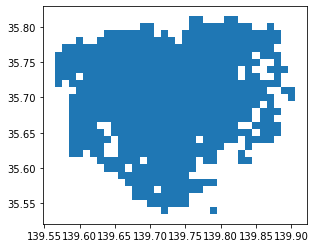

In [3]:
gdf[gdf.distance_park==0].plot()

## Calculate projected geometries

In [4]:
gdf.crs = {'init': 'epsg:4326'}
gdf_proj = gdf.to_crs(epsg=3857)
gdf_proj.head()

,geohash,count_buildings,distance_park,geometry
0,xn76htc7t01vcm742q01,2,1290.0,"POLYGON ((15559681.826 4236825.291, 15559681.8..."
1,xn76kc88n06qddh3jd96,2,1530.0,"POLYGON ((15560795.021 4239561.559, 15560795.0..."
2,xn76tdtg61hkpvf1dtvt,1,1530.0,"POLYGON ((15565247.800 4246405.219, 15565247.8..."
3,xn76sbzcp0fzggmy6gdm,1,1230.0,"POLYGON ((15561908.215 4245036.145, 15561908.2..."
4,xn769k7mwc60x0pjn21n,3,630.0,"POLYGON ((15544097.097 4247774.464, 15544097.0..."


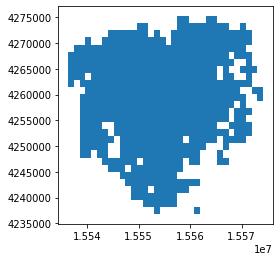

In [5]:
gdf_proj[gdf_proj.distance_park==0].plot()

## Plot projected
https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html

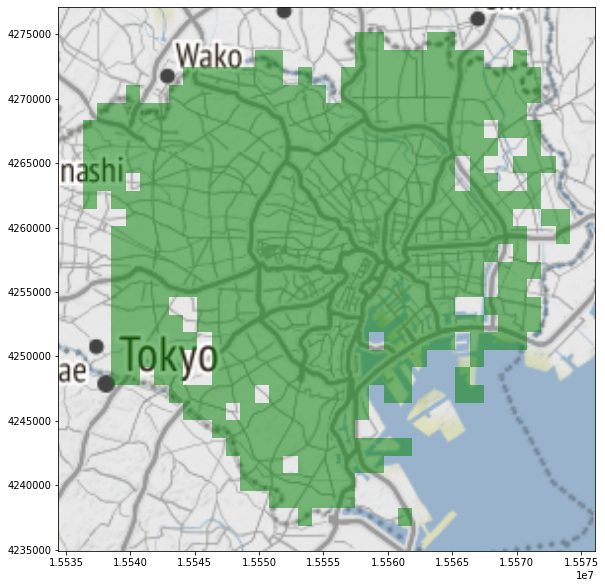

In [6]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

ax = gdf_proj[gdf_proj.distance_park==0].plot(figsize=(10, 10), alpha=.5, color='green')
add_basemap(ax, zoom=10)

## Aggregate distances

In [7]:
gdf_proj_total = gdf_proj.groupby(['geohash']).agg({'count_buildings':sum, 'geometry': 'first'})

distance = 60
gdf_proj_distance = gdf_proj[gdf_proj.distance_park<=distance]\
    .groupby(['geohash']).agg({'count_buildings':sum, 'geometry': 'first'})
gdf_proj_distance['count_buildings_total'] = gdf_proj_total[['count_buildings']]
gdf_proj_distance['ratio'] = gdf_proj_distance.count_buildings/gdf_proj_distance.count_buildings_total
gdf_proj_distance.head()

,count_buildings,geometry,count_buildings_total,ratio
geohash,,,,
xn75pyxu0dwgxrwwnwfs,34,"POLYGON ((15537417.927 4261476.342, 15537417.9...",82,0.414634
xn75rbry2dybp6n9w94s,13,"POLYGON ((15537417.927 4262847.475, 15537417.9...",50,0.260000
xn75rfrb8dyurkqsye6t,44,"POLYGON ((15537417.927 4264218.780, 15537417.9...",244,0.180328
xn75rupfbenbxqy8ntdw,137,"POLYGON ((15537417.927 4265590.257, 15537417.9...",402,0.340796
xn75rvzv0envp3neqxfw,163,"POLYGON ((15537417.927 4266961.906, 15537417.9...",297,0.548822


## Plot animation

In [8]:
fig, ax = plt.subplots(figsize=(9,9))
plt.axis('off');

plt.suptitle('Animate Tokyo buildings distance to nearest parks', fontsize=18)

xmin, ymin, xmax, ymax = gdf_proj.geometry.total_bounds
basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=10,
                                 url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png')
ax.imshow(basemap, extent=extent, interpolation='bilinear')
ax.axis((xmin, xmax, ymin, ymax))

ims = []
def updatefig(j):
    global ims, ax
    for im in ims:
        im.remove()
    # distances defined as 0m, 30m, 60m, ...
    distance = 30*j
    ax.set_title('%d meters or less' % (distance + 30), fontsize=18)
    
    gdf_proj_distance = gdf_proj[gdf_proj.distance_park<=distance]\
    .groupby(['geohash']).agg({'count_buildings':sum, 'geometry': 'first'})
    gdf_proj_distance['count_buildings_total'] = gdf_proj_total[['count_buildings']]
    gdf_proj_distance['ratio'] = gdf_proj_distance.count_buildings/gdf_proj_distance.count_buildings_total

    # high ration
    gdf_subset = gdf_proj_distance[gdf_proj_distance.ratio>=0.8]
    patches = [PolygonPatch(geom) for geom in gdf_subset.geometry]
    coll = PatchCollection(patches,color='green',alpha=0.5,edgecolor='None')
    im1 = ax.add_collection(coll)
    
    # medium ratio
    gdf_subset = gdf_proj_distance[(gdf_proj_distance.ratio<0.8)&(gdf_proj_distance.ratio>=0.5)]
    patches = [PolygonPatch(geom) for geom in gdf_subset.geometry]
    coll = PatchCollection(patches,color='yellow',alpha=0.3,edgecolor='None')
    im2 = ax.add_collection(coll)
    
    # low ratio
    gdf_subset = gdf_proj_distance[gdf_proj_distance.ratio<0.5]
    patches = [PolygonPatch(geom) for geom in gdf_subset.geometry]
    coll = PatchCollection(patches,color='red',alpha=0.3,edgecolor='None')
    im3 = ax.add_collection(coll)
    
    ims = [im1,im2,im3]
    return

anim = animation.FuncAnimation(fig, updatefig, frames=range(20), interval=500)
plt.close(anim._fig)
HTML(anim.to_html5_video())